<a href="https://colab.research.google.com/github/ppkgtmm/sentiment/blob/emb/EMB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install keras-tuner
# !rm -r sentiment
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [12]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense, Embedding, Flatten
from keras.models import Sequential
from keras.metrics import Precision, Recall, FalseNegatives, \
FalsePositives, TrueNegatives, TruePositives
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate

In [4]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/sentiment/data/data_preprocessed.csv'
test_path = '/content/drive/MyDrive/sentiment/data/test_data_preprocessed.csv'
seed = 123456
num_words = 10000
max_len = 250
optimizers = [
           'Adam',
           'RMSprop'   
]

In [5]:
data = read_data(data_path,cols)
data.sample(5)

,text,target
67068,entertaining and should not be compared to the...,1
128812,beware i bought this tub and surround at lowe ...,0
181069,more anti semitic drivel from an anti israel w...,0
43999,offensive drivel describes gay sex as and gay ...,0
331800,great quality and shipping time i would like t...,1


In [21]:
test = read_data(test_path, cols)
test.sample(5)

,text,target
3438,boring gosh this movie was sooooooo long what ...,0
15956,a shower radio that is does not work well with...,0
5050,might as well use a ziploc bag these bags are ...,0
18506,too much in this madness method actress piper ...,0
13755,adventures down under series right at the begi...,1


In [6]:
train, val = split_data(data)

In [7]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [8]:
sequence_train = get_sequences(tokenizer, max_len, train['text'])
sequence_val = get_sequences(tokenizer, max_len, val['text'])

In [9]:
print(val['target'].unique(), train['target'].unique())

[1 0] [0 1]


In [10]:
train_target = OH_fit_transform(train['target'])
val_target = OH_transform(val['target'])

## Embedding

In [13]:
def build_emb(hp):
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(
        Embedding(
          num_words, hp.get('output_dim')
        )
    )
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=hp.get('optimizer'),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall(),
                 TruePositives(), 
                 TrueNegatives(), 
                 FalsePositives(),
                 FalseNegatives()
              ]
          )
    model.summary()
    return model

In [11]:
hp = HyperParameters()
hp.Int('output_dim', 64, 256, 64)
hp.Choice('optimizer', optimizers)

'Adam'

In [18]:
tuner = get_tuner(build_emb,'/content/drive/MyDrive/sentiment/EMB',\
                  'EMB_B32',hp, 1, 2)

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/sentiment/EMB/EMB_B32/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
flatten (Flatten)            (None, 16000)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 32002     
Total params: 672,002
Trainable params: 672,002
Non-trainable params: 0
_________________________________________________________________


## Train

In [19]:
history = tuner.search(
    sequence_train,
    train_target,
    epochs=1,
    validation_data=(sequence_val, val_target),
    batch_size=32
)

Trial 10 Complete [00h 21m 14s]
val_loss: 0.3038584589958191

Best val_loss So Far: 0.26680660247802734
Total elapsed time: 02h 10m 24s
INFO:tensorflow:Oracle triggered exit


## Refit

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [30]:
best_model = get_model_from_config(
    best_model,
    tuner.get_best_hyperparameters()[0].get('optimizer')
)

In [31]:
cb = get_callbacks('emb.h5')

In [ ]:
history = best_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs=100,
    callbacks=cb
)

Epoch 1/100
9563/9563 [==============================] - 109s 11ms/step - loss: 0.3309 - accuracy: 0.8536 - precision: 0.8536 - recall: 0.8536 - true_positives: 133634.3377 - true_negatives: 133634.3377 - false_positives: 19405.6531 - false_negatives: 19405.6531 - val_loss: 0.2639 - val_accuracy: 0.8963 - val_precision: 0.8963 - val_recall: 0.8963 - val_true_positives: 48397.0000 - val_true_negatives: 48397.0000 - val_false_positives: 5601.0000 - val_false_negatives: 5601.0000

Epoch 00001: val_loss improved from inf to 0.26387, saving model to emb.h5
Epoch 2/100
9033/9563 [===========================>..] - ETA: 5s - loss: 0.1941 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - true_positives: 133809.3533 - true_negatives: 133809.3533 - false_positives: 10734.6467 - false_negatives: 10734.6467

## Test

In [22]:
sequence_test = get_sequences(tokenizer, max_len, test['text'])
test_target = OH_transform(test['target'])

 62/625 [=>............................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 1s 2ms/step
Accuracy:	89.4%


              precision    recall  f1-score   support

           0       0.90      0.89      0.89     10000
           1       0.89      0.90      0.90     10000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



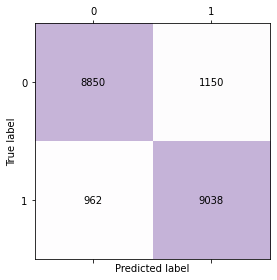

In [25]:
model_evaluate(best_model, sequence_test, test_target, 32)

## Insights

In [26]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': None}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop'], 'ordered': False}


In [28]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/sentiment/EMB/EMB_B32
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
output_dim: 64
optimizer: Adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.26680660247802734
Trial summary
Hyperparameters:
output_dim: 64
optimizer: RMSprop
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.26700088381767273
Trial summary
Hyperparameters:
output_dim: 64
optimizer: Adam
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: e7d8a78041639d14031e3fafc062b3b6
Score: 0.269220694899559
